# **Gopay Mobile App Reviews Sentiment Analysis & Topic Modeling** 

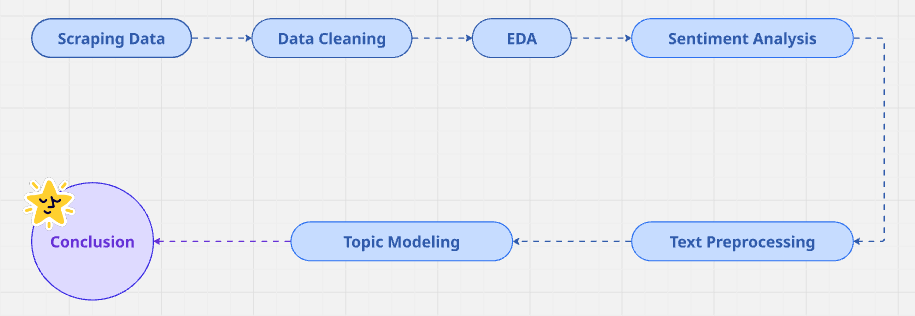

## Outline Of The Project

- Scraping Data : Collecting data from google play store website
- Data Cleaning : Fixing messy data like removing duplicates, handling missing values, or correcting errors.
- EDA : Taking a first look at the data with charts and stats to understand patterns and problems.
- Sentiment Analysis : Finding out if people’s opinions in the text are positive, negative, or neutral.
- Text Preprocessing : Preparing text or numbers for analysis, such as tokenizing words, normalizing, or scaling values.
- Topic Modeling : Discovering the main themes or topics that appear in a large collection of text.
- Conclusion : Summarizing the findings and insights from all the steps to answer the main question.

---

# 🚨 Install & Import Library

## Install Library

In [1]:
#google play scraper : Used to collect app data and user reviews directly from Google Play Store.
!pip install google-play-scraper

In [2]:
# Creates visual word clouds to highlight the most frequent words in text data.
!pip install wordcloud
# Adds a simple progress bar to loops, so you can see how long a process takes.
!pip install tqdm
# A toolkit for natural language processing, like tokenizing, stemming, or removing stopwords.
!pip install nltk
# Provides powerful pre-trained models for tasks such as text classification, sentiment analysis, and translation.
!pip install transformers

In [3]:
# to discover and understand hidden topics in documents or user reviews without manually reading them one by one
!pip install bertopic

## Import Library

In [4]:
# Import library for play store reviews scraping
from google_play_scraper import Sort, reviews
import pandas as pd

In [5]:
# Import library for visualize data
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Import library for teks processing & model inference
import re
import string
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
tqdm.pandas()
import asyncio
import time
import transformers
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Import library for topic modeling
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP

---

# 🗃️ Scraping Data

Scrape user reviews of the GoPay application from the Google Play Store and save the scraped data into a CSV file.

In [37]:
result = reviews(
    'com.gojek.gopay', # Id gopay mobile app in play store
    lang='id', # languege code reviews
    country='id', # country code reviews
    sort=Sort.MOST_RELEVANT, # filtering method reviews
    count=7000 # count of data reviews
)

In [38]:
result = pd.DataFrame(result[0]) # Convert data scraping into table dataframe
result.info() # To show feature, count & type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              7000 non-null   object        
 1   userName              7000 non-null   object        
 2   userImage             7000 non-null   object        
 3   content               7000 non-null   object        
 4   score                 7000 non-null   int64         
 5   thumbsUpCount         7000 non-null   int64         
 6   reviewCreatedVersion  6925 non-null   object        
 7   at                    7000 non-null   datetime64[ns]
 8   replyContent          4517 non-null   object        
 9   repliedAt             4517 non-null   datetime64[ns]
 10  appVersion            6925 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 601.7+ KB


In [39]:
data = result.to_csv('result.csv', index=False) # Save dataframe as csv file

---

# 🧼 Data Cleaning

This step is about cleaning the raw scraped data to make it ready for the next stages, such as handling duplicates, missing values, or incorrect data types.

## Delete Missing & Duplicate Rows

In [40]:
# Load csv file
data = pd.read_csv('result.csv')
# Remove feature not have insight
data = data.drop(['reviewId','userName', 'userImage', 'reviewCreatedVersion', 'replyContent', 'repliedAt'],axis=1)

In [41]:
data = data.drop_duplicates() # remove duplicated rows
data = data.dropna() # remove missing rows

data.info() # show results

<class 'pandas.core.frame.DataFrame'>
Index: 6925 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6925 non-null   object
 1   score          6925 non-null   int64 
 2   thumbsUpCount  6925 non-null   int64 
 3   at             6925 non-null   object
 4   appVersion     6925 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.6+ KB


## Data Transformation

### Month

In [42]:
data['at'] = pd.to_datetime(data['at']) # Convert feature at type to datetime type
data = data[data['at'].dt.year == 2025] # Extract data only in 2025

data['month'] = data['at'].dt.month.astype('str') # Extract mont feature & make it string type
data = data.drop(columns=['at'], axis=1) # Deleted at feature
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6925 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6925 non-null   object
 1   score          6925 non-null   int64 
 2   thumbsUpCount  6925 non-null   int64 
 3   appVersion     6925 non-null   object
 4   month          6925 non-null   object
dtypes: int64(2), object(3)
memory usage: 324.6+ KB


In [43]:
data.head() # Results

,content,score,thumbsUpCount,appVersion,month
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,37,1.56.1,8
1,utamakan efektivitas tolong kurangi animasi yg...,3,12,1.57.0,8
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,28,1.56.1,8
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,1.56.1,8
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,57,1.53.0,8


### App Version

In [44]:
print(data['appVersion'].unique()) # Check app version unique value

['1.56.1' '1.57.0' '1.53.0' '1.52.0' '1.54.0' '1.51.0' '1.49.1' '1.48.0'
 '1.45.0' '1.46.1' '1.47.0' '1.44.0' '1.49.0' '1.56.0' '1.39.0' '1.26.1'
 '1.21.0' '1.15.1']


In [45]:
data['minorVersion'] = data['appVersion'] # Change feature appVersion name to minorVersion
data = data.drop(columns=['appVersion'], axis=1) # Deleted appVersion feature
data['majorVersion'] = data['minorVersion'].str[:3] # Round minorVersion value & save to majorVersion feature
data.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,37,8,1.56.1,1.5
1,utamakan efektivitas tolong kurangi animasi yg...,3,12,8,1.57.0,1.5
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,28,8,1.56.1,1.5
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,8,1.56.1,1.5
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,57,8,1.53.0,1.5


In [46]:
print(data['majorVersion'].unique()) # To show unique value of majorVersion

['1.5' '1.4' '1.3' '1.2' '1.1']


---

# 🔎 Exploratory Data Analysis

## Data Deskriptif

In [18]:
data.describe() # To show statistcs summary from data

,score,thumbsUpCount
count,6925.000000,6925.000000
mean,2.625415,6.478845
std,1.781878,32.684035
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,2.000000
max,5.000000,1419.000000


## Score

<Axes: xlabel='score', ylabel='count'>

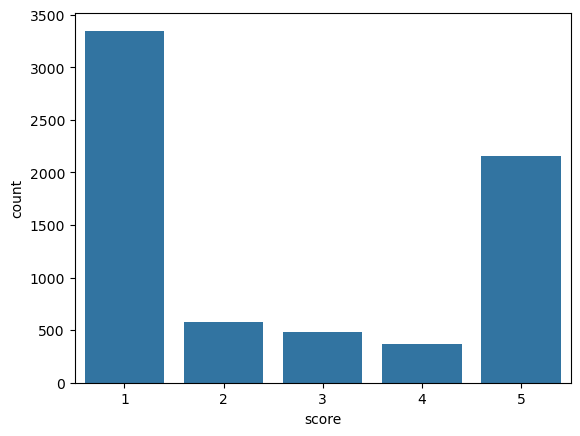

In [19]:
sns.countplot(data=data, x='score') # To show score distribution

## Month

<Axes: xlabel='month', ylabel='count'>

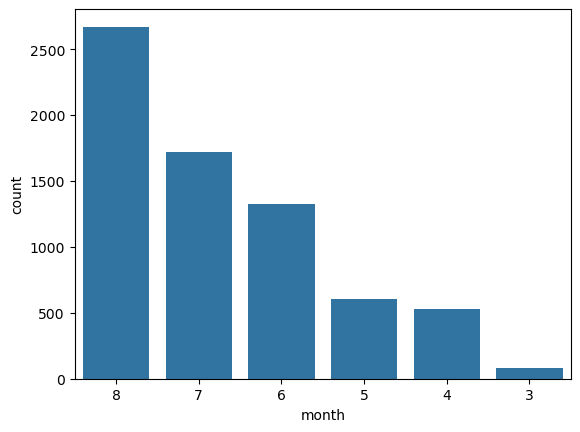

In [20]:
sns.countplot(data=data, x='month') # To show user reviews distribution of the month

## Major Version

<Axes: xlabel='majorVersion', ylabel='count'>

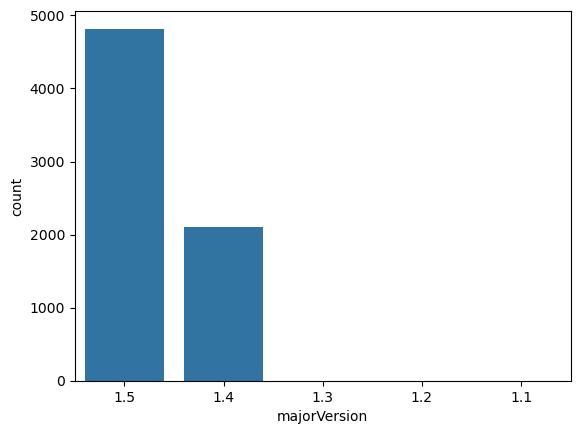

In [21]:
sns.countplot(data=data, x='majorVersion') # To show major version app distribution

## Score VS Thumbs Up Count

<Axes: xlabel='score', ylabel='thumbsUpCount'>

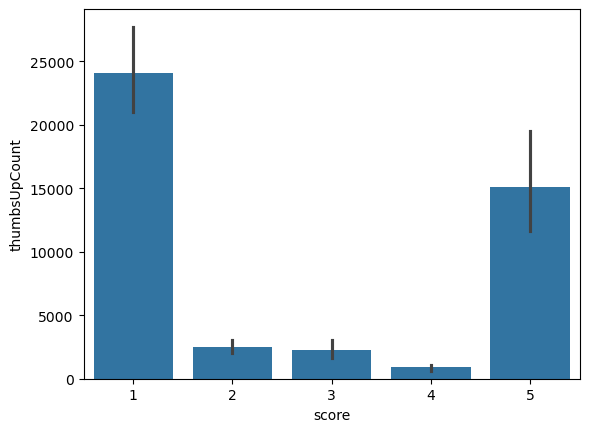

In [22]:
#
sns.barplot(data=data, x='score', y='thumbsUpCount', estimator="sum")

## Major Version VS Score

<Axes: xlabel='majorVersion', ylabel='score'>

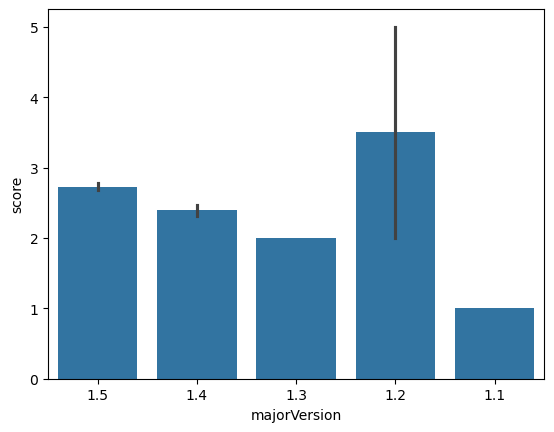

In [23]:
# To show mean score per category major version
sns.barplot(data=data, x='majorVersion', y='score')

## Month VS Major Version

<Axes: xlabel='month', ylabel='Count'>

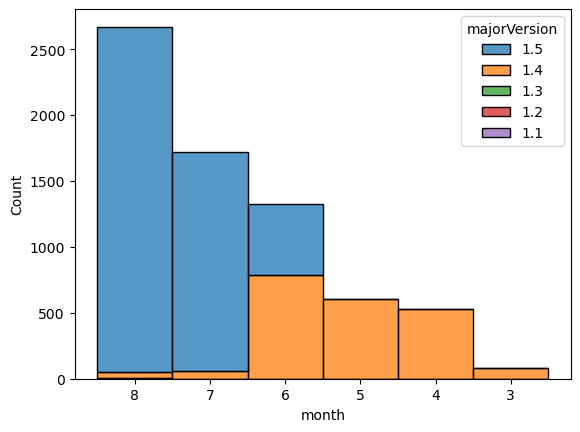

In [24]:
# To show count of major version per month in 2025
sns.histplot(data=data, x='month', hue='majorVersion', multiple="stack")

In [25]:
# To show detailed mean score of major version per month in 2025
data.pivot_table(index='majorVersion',
                columns='month',
                values='score',
                aggfunc='mean')

month,3,4,5,6,7,8
majorVersion,,,,,,
1.1,NaN,NaN,NaN,NaN,NaN,1.000000
1.2,NaN,NaN,5.000000,NaN,NaN,2.000000
1.3,NaN,NaN,NaN,NaN,2.000000,NaN
1.4,2.115385,2.446768,2.362438,2.331633,2.762712,3.081633
1.5,NaN,NaN,NaN,2.157699,2.703614,2.860634


---

# 🤬 Sentiment Analysis

In [47]:
def sentiment(score):
    if score in [1,2,3]:
        return "NEGATIVE"
    else:
        return "POSITIVE"

In [48]:
data['labels'] = data["score"].progress_apply(sentiment) # Save sentiment labels in labels feature on data dataframe
data.head()

100% 6925/6925 [00:00<00:00, 720804.92it/s]


,content,score,thumbsUpCount,month,minorVersion,majorVersion,labels
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,37,8,1.56.1,1.5,NEGATIVE
1,utamakan efektivitas tolong kurangi animasi yg...,3,12,8,1.57.0,1.5,NEGATIVE
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,28,8,1.56.1,1.5,NEGATIVE
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,8,1.56.1,1.5,NEGATIVE
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,57,8,1.53.0,1.5,NEGATIVE


## EDA Sentiment Labels

### Sentiment Distribution

<Axes: xlabel='labels', ylabel='count'>

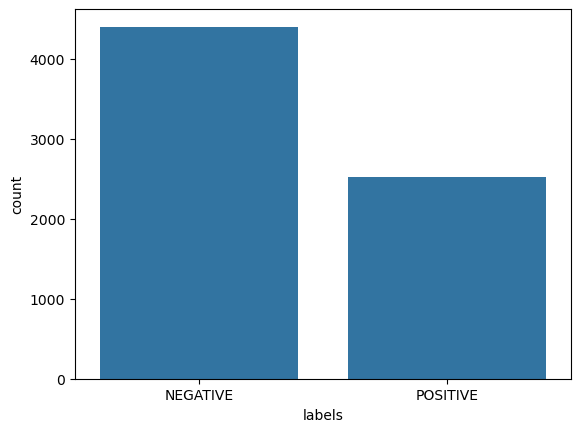

In [28]:
# To show sentiment labels distributions
sns.countplot(data=data, x='labels')

### Sentiment VS Thumbs Up Count

<Axes: xlabel='labels', ylabel='thumbsUpCount'>

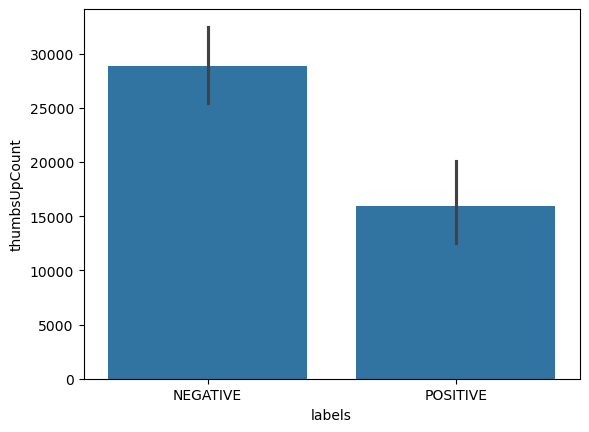

In [29]:
# To see count total of thumbs up count per labels
sns.barplot(data=data, x="labels", y="thumbsUpCount", estimator="sum")

### Sentiment VS Month

<Axes: xlabel='month', ylabel='Count'>

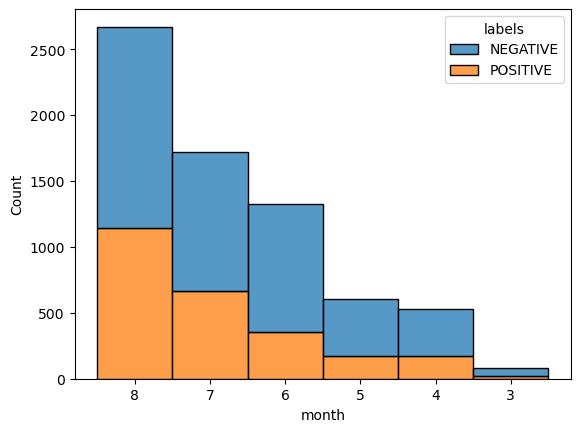

In [30]:
# To show labels distributions per month in 2025
sns.histplot(data=data, x="month", hue="labels", multiple="stack")

### Sentiment VS Major Version

<Axes: xlabel='majorVersion', ylabel='Count'>

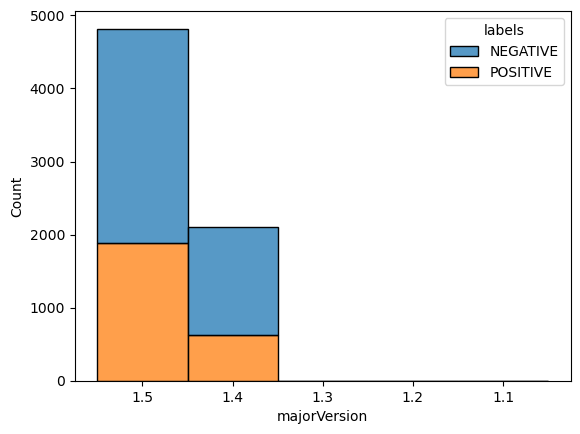

In [31]:
# To show labels distributions per major version app
sns.histplot(data=data, x="majorVersion", hue="labels", multiple="stack")

---

# 📜 Text Preprocessing

In [32]:
# Collect and filtering data from content feature and make it a new dataframe
docs = pd.DataFrame(data['content'].reset_index(drop=True), columns=['content'])

### Document Translated Model

In [49]:
translator = pipeline(
    "translation", #pipeline model type
    model="facebook/nllb-200-distilled-600M", # name of model for translation
    src_lang="ind_Latn", # id/ code first language
    tgt_lang="eng_Latn" # id/ code output language
)

Device set to use cuda:0


In [50]:
# Function for translation teks in docs
def translate(text):
  return translator(text)[0]["translation_text"]

In [51]:
# Apply function translation in data content feature
docs['text_translate'] = docs['content'].progress_apply(translate)

 47% 3239/6925 [10:14<08:22,  7.34it/s]Your input_length: 183 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
 59% 4055/6925 [12:56<09:15,  5.17it/s]Your input_length: 228 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
100% 6925/6925 [19:31<00:00,  5.91it/s]


### Documen/ Text Cleanning

In [52]:
# Download NLTK resources if not already available
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# 1. Remove numbers, symbols, emojis, links, mentions, etc.
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)       # remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)       # remove hashtags
    text = re.sub(r'RT[\s]+', '', text)              # remove retweets "RT"
    text = re.sub(r"http\S+", '', text)              # remove URLs
    text = re.sub(r'[0-9]+', '', text)               # remove numbers
    text = re.sub(r'[^\w\s]', '', text)              # remove symbols/emoji
    text = text.replace('\n', ' ')                   # remove newlines
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip()
    return text

# 2. Lowercasing
def casefoldingText(text):
    return text.lower()

# 3. Tokenization
def tokenizing(text):
    return word_tokenize(text)

# 4. Remove stopwords
def stopwordstext(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# 5. Lemmatization
def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(processed_tokens)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
# Apply all function of text preprocessing
docs['text_clean'] = docs['text_translate'].progress_apply(cleaningText)
docs['text_lower'] = docs['text_clean'].progress_apply(casefoldingText)
docs['text_tokenizing'] = docs['text_lower'].progress_apply(tokenizing)
docs['text_stopwords'] = docs['text_tokenizing'].progress_apply(stopwordstext)
docs['text_akhir'] = docs['text_stopwords'].progress_apply(lemmatizing)

100% 6925/6925 [00:00<00:00, 128383.25it/s]
100% 6925/6925 [00:00<00:00, 2848720.60it/s]
100% 6925/6925 [00:00<00:00, 37346.48it/s]
100% 6925/6925 [00:00<00:00, 45740.02it/s]
100% 6925/6925 [00:00<00:00, 7305.12it/s]


In [54]:
docs.head()

,content,text_translate,text_clean,text_lower,text_tokenizing,text_stopwords,text_akhir
0,"aplikasinya bagus aja, cuma ad sedikit masalah...","It's a good app, but it's just a little bit of...",Its a good app but its just a little bit of a ...,its a good app but its just a little bit of a ...,"[its, a, good, app, but, its, just, a, little,...","[good, app, little, bit, problem, trying, pay,...",good app little bit problem trying pay topup g...
1,utamakan efektivitas tolong kurangi animasi yg...,please reduce the unnecessary animation to lig...,please reduce the unnecessary animation to lig...,please reduce the unnecessary animation to lig...,"[please, reduce, the, unnecessary, animation, ...","[please, reduce, unnecessary, animation, light...",please reduce unnecessary animation lighten ap...
2,aplikasi nya udh bagus seperti yang lainnya ta...,"The app is just as good as the others, but the...",The app is just as good as the others but ther...,the app is just as good as the others but ther...,"[the, app, is, just, as, good, as, the, others...","[app, good, others, theres, lot, weirdness, li...",app good others there lot weirdness like spin ...
3,Cukup kecewa update kali ini. Mengapa sistem b...,I'm pretty disappointed with the update this t...,Im pretty disappointed with the update this ti...,im pretty disappointed with the update this ti...,"[im, pretty, disappointed, with, the, update, ...","[im, pretty, disappointed, update, time, curre...",im pretty disappointed update time current gop...
4,"promo tak sesuai kenyataan, harga ternyata leb...","The promo is unrealistic, the price turns out ...",The promo is unrealistic the price turns out t...,the promo is unrealistic the price turns out t...,"[the, promo, is, unrealistic, the, price, turn...","[promo, unrealistic, price, turns, expensive, ...",promo unrealistic price turn expensive app ive...


In [55]:
docs = docs["text_akhir"].reset_index(drop=True)
data = data.reset_index(drop=True)

docs = pd.concat([data,docs], axis=1)
docs.head()

,content,score,thumbsUpCount,month,minorVersion,majorVersion,labels,text_akhir
0,"aplikasinya bagus aja, cuma ad sedikit masalah...",3,37,8,1.56.1,1.5,NEGATIVE,good app little bit problem trying pay topup g...
1,utamakan efektivitas tolong kurangi animasi yg...,3,12,8,1.57.0,1.5,NEGATIVE,please reduce unnecessary animation lighten ap...
2,aplikasi nya udh bagus seperti yang lainnya ta...,2,28,8,1.56.1,1.5,NEGATIVE,app good others there lot weirdness like spin ...
3,Cukup kecewa update kali ini. Mengapa sistem b...,2,22,8,1.56.1,1.5,NEGATIVE,im pretty disappointed update time current gop...
4,"promo tak sesuai kenyataan, harga ternyata leb...",1,57,8,1.53.0,1.5,NEGATIVE,promo unrealistic price turn expensive app ive...


---

# 💭 Topic Modeling

## Data/ Document Splitting

In [68]:
# Splitting data into two different dataframe such as negative & positive
negative = docs[docs['labels']=='NEGATIVE']['text_akhir']
positive = docs[docs['labels']=='POSITIVE']['text_akhir']

## Topic Modeling Model

In [59]:
# Load embedding model: converts text into semantic vectors
embedding_model = pipeline(
    "feature-extraction",
    model="princeton-nlp/sup-simcse-roberta-large"
)
# "sup-simcse-roberta-large" is a RoBERTa-based model fine-tuned for semantic similarity

# Dimensionality reduction model (UMAP)
umap_model = UMAP(
    n_neighbors=15, # consider 15 nearest neighbors to preserve local structure
    n_components=5, # reduce embeddings to 5 dimensions
    min_dist=0.0, # allows points to be packed more closely
    metric='cosine', # measure distance based on cosine similarity
    random_state=42
)

# Vectorizer: converts text into token counts
vectorizer_model = CountVectorizer(
    min_df=10, # only keep words/phrases that appear at least 10 times
    stop_words="english"
)

# Class-based TF-IDF transformer
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
# - Uses BM25 weighting for more accurate class-based keyword extraction

# Keyword representation model using Maximal Marginal Relevance (MMR)
representation_model = MaximalMarginalRelevance(diversity=0.3)
# - diversity=0.3: balance between relevance and diversity of selected keywords

def topic(n_cluster):
    # Function to create a BERTopic model with a fixed number of clusters
    topic_model = BERTopic(
        embedding_model=embedding_model,           # text embeddings
        umap_model=umap_model,                     # dimensionality reduction
        hdbscan_model=KMeans(n_clusters=n_cluster),
        # use Agglomerative Clustering instead of default HDBSCAN
        # number of clusters defined by n_cluster

        vectorizer_model=vectorizer_model,         # text to tokens
        ctfidf_model=ctfidf_model,                 # topic representation with C-TF-IDF
        representation_model=representation_model, # keyword extraction with MMR
        calculate_probabilities=True,              # compute topic probabilities per document
        verbose=True                               # show training logs
    )
    return topic_model

Device set to use cuda:0


## Negative Topic

### Topic Modelling

In [69]:
negative_topic = topic(25) # Output 25 topics
negative_info = negative_topic.fit_transform(negative)
negative_info = negative_topic.get_topic_info()
negative_info.to_excel('negative_topic.xlsx')
negative_info

2025-09-01 06:59:31,065 - BERTopic - Embedding - Transforming documents to embeddings.
100% 4404/4404 [00:18<00:00, 234.73it/s]
2025-09-01 06:59:49,838 - BERTopic - Embedding - Completed ✓
2025-09-01 06:59:49,839 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-01 06:59:53,011 - BERTopic - Dimensionality - Completed ✓
2025-09-01 06:59:53,011 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-01 06:59:53,021 - BERTopic - Cluster - Completed ✓
2025-09-01 06:59:53,022 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-01 06:59:55,721 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,286,0_cashback_voucher_promo_wdp,"[cashback, voucher, promo, wdp, discount, scam...",[exchange direct gift exchange gopay voucher w...
1,1,281,1_didnt_bank_worked_payment,"[didnt, bank, worked, payment, account, return...",[sent balance transaction statement fund succe...
2,2,269,2_app_doesnt_download_buy,"[app, doesnt, download, buy, sent, disappointe...",[clear topup buy data package dont come three ...
3,3,264,3_account_payment_transfer_transaction,"[account, payment, transfer, transaction, lost...",[brother ive using gopay long time recently go...
4,4,261,4_network_update_apk_fix,"[network, update, apk, fix, phone, app, error,...",[cellular signal data network still good go ap...
5,5,242,5_transaction_successful_saving_bank,"[transaction, successful, saving, bank, fund, ...",[top balance transaction history successfully ...
6,6,237,6_disappointed_low_app_payment,"[disappointed, low, app, payment, service, tra...","[im disappointed july, ive gopay user long tim..."
7,7,221,7_long_wait_time_topup,"[long, wait, time, topup, work, salary, transa...",[ive waiting process four day waiting list fou...
8,8,189,8_lost_transaction_failed_error,"[lost, transaction, failed, error, gopays, dis...",[bad losing money money doesnt come back money...
9,9,188,9_didnt_worked_fix_evidence,"[didnt, worked, fix, evidence, disappointed, t...",[didnt topup come already balance notification...


### Sub Topic Intepretation

In [70]:
negative_topic.set_topic_labels({
    0: "Login & Account Access", 1: "Balance Not Credited", 2: "Facial Verification Failed", 3: "Customer Service Delay",4: "App Performance Issues",
    5: "Promo Voucher Failure", 6: "GoPay Plus Account Issues", 7: "Balance Cuts & Missing Top-ups",8: "Loan Denied", 9: "App Bugs & Errors",
    10: "Promo & Gift Frustration", 11: "Connectivity & Chat Issues", 12: "Fewer Discounts", 13: "Unreliable Game Top-ups", 14: "Balance Deducted Without Funds",
    15: "Delayed Bank Transfers", 16: "Missing Cashback/Promo", 17: "Cannot Claim Gifts/Promo", 18: "Top-up Deducted, Not Credited", 19: "Recent Top-ups Not Reflected",
    20: "Account Access Problems", 21: "Mandatory App Update Blocks Login", 22: "Delayed Balance After Bank Top-up", 23: "Payment/Service Access Blocked", 24: "Update Prompts & Intrusive Ads"
})

negative_info = negative_topic.get_document_info(negative)
negative_info["Sub Topic"] = negative_info["CustomName"]
negative_info = negative_info[["Document","Topic", "Sub Topic"]]
negative_info.head()

,Document,Topic,Sub Topic
0,good app little bit problem trying pay topup g...,4,App Performance Issues
1,please reduce unnecessary animation lighten ap...,4,App Performance Issues
2,app good others there lot weirdness like spin ...,15,Delayed Bank Transfers
3,im pretty disappointed update time current gop...,6,GoPay Plus Account Issues
4,promo unrealistic price turn expensive app ive...,2,Facial Verification Failed


### Topic Sanitizing/ Clusterring

In [71]:
def get_topic_group(topic_number):
    if topic_number in [0, 6, 20, 21, 23]:
        return "Login & Account Access"
    elif topic_number in [1, 7, 14, 15, 18, 19, 22]:
        return "Balance & Transaction History"
    elif topic_number in [2, 8]:
        return "Verification & Loan Issues"
    elif topic_number == 3:
        return "Customer Service"
    elif topic_number in [4, 9, 11, 24]:
        return "App Performance & Features"
    else:
        return "Promotions, Vouchers & Cashback"

negative_info["Main Topic"] = negative_info["Topic"].progress_apply(get_topic_group)
negative_info = negative_info[["Document","Main Topic", "Sub Topic"]]

negative = data[data['labels']=='NEGATIVE'][["thumbsUpCount","month", "minorVersion","majorVersion"]]
negative_info = pd.concat([negative_info.reset_index(drop=True), negative.reset_index(drop=True)], axis=1)
negative_info

100% 4404/4404 [00:00<00:00, 624234.22it/s]


,Document,Main Topic,Sub Topic,thumbsUpCount,month,minorVersion,majorVersion
0,good app little bit problem trying pay topup g...,App Performance & Features,App Performance Issues,37,8,1.56.1,1.5
1,please reduce unnecessary animation lighten ap...,App Performance & Features,App Performance Issues,12,8,1.57.0,1.5
2,app good others there lot weirdness like spin ...,Balance & Transaction History,Delayed Bank Transfers,28,8,1.56.1,1.5
3,im pretty disappointed update time current gop...,Login & Account Access,GoPay Plus Account Issues,22,8,1.56.1,1.5
4,promo unrealistic price turn expensive app ive...,Verification & Loan Issues,Facial Verification Failed,57,8,1.53.0,1.5
...,...,...,...,...,...,...,...
4399,cant believe im toping rb notifying balance is...,Balance & Transaction History,Balance Not Credited,0,8,1.53.0,1.5
4400,aqs bankruptcy safety unsecured there purchase...,Verification & Loan Issues,Loan Denied,0,6,1.49.1,1.4
4401,gopay complicated sich ad transfer gopay accou...,Customer Service,Customer Service Delay,0,6,1.51.0,1.5
4402,didnt come,Balance & Transaction History,Balance Not Credited,0,8,1.53.0,1.5


### EDA (Topic)

#### Main Topic

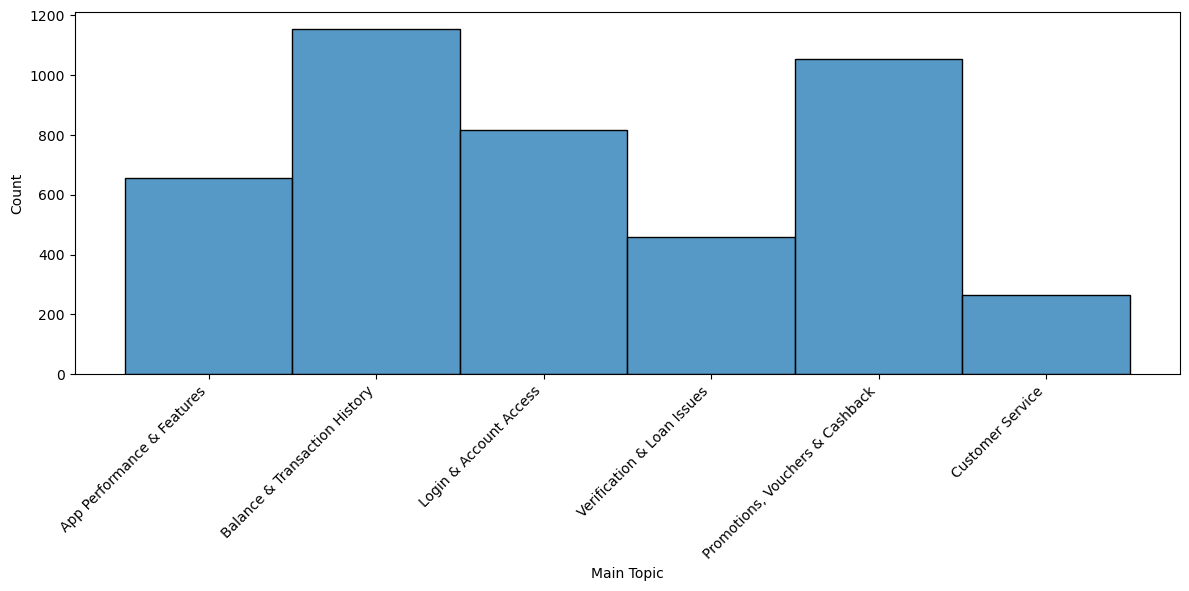

In [72]:

plt.figure(figsize=(12, 6))
sns.histplot(data=negative_info, x="Main Topic")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Main Topic VS Thumb Up Count

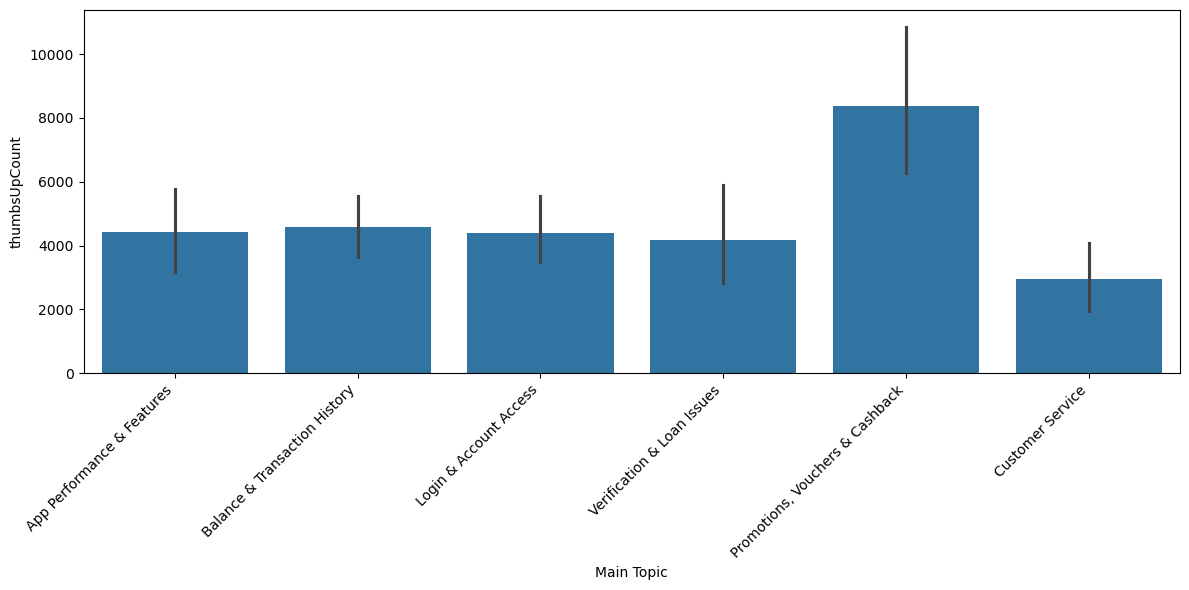

In [73]:
plt.figure(figsize=(12, 6))
sns.barplot(data=negative_info, x="Main Topic", y="thumbsUpCount", estimator='sum')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Main Topic VS Major Version

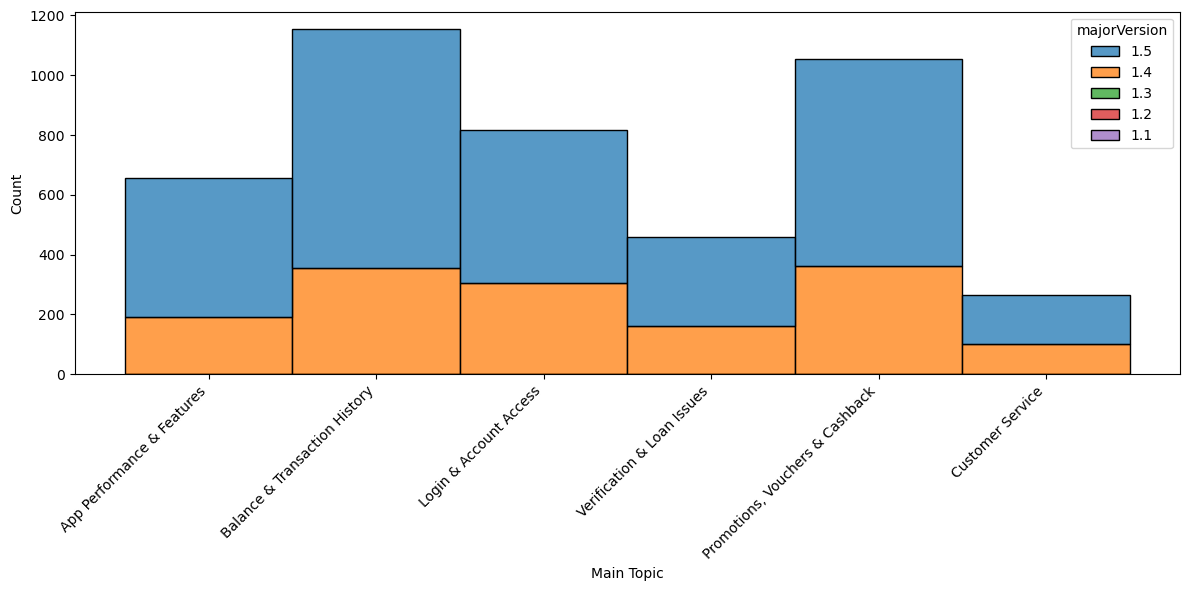

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(data=negative_info, x="Main Topic", hue="majorVersion", multiple="stack")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Main Topic VS Month

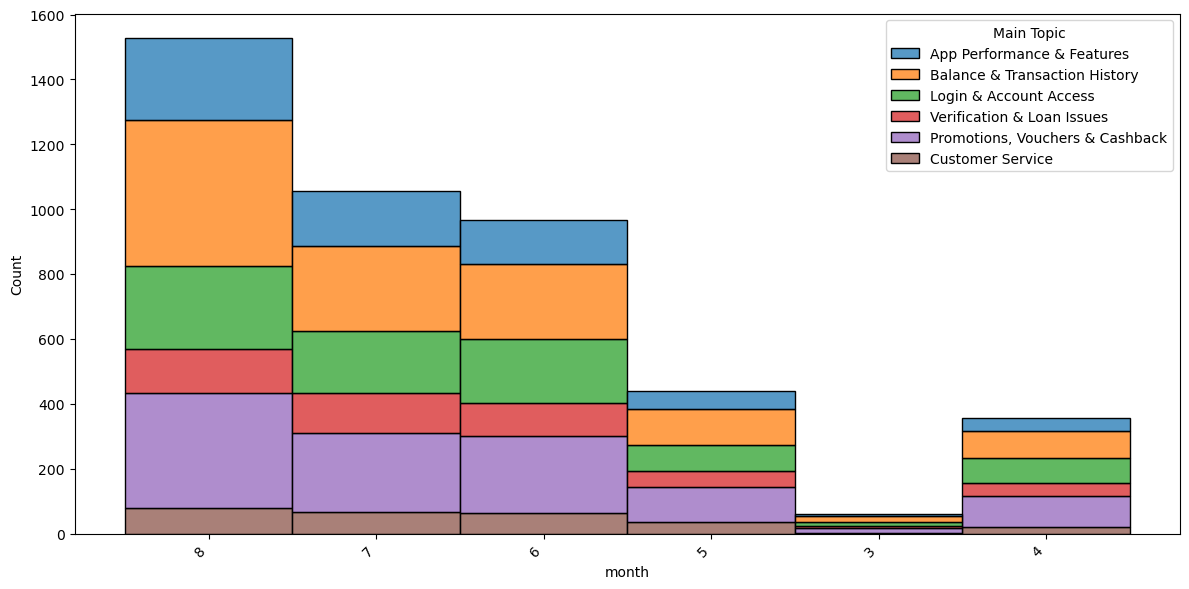

In [83]:
plt.figure(figsize=(12, 6))
sns.histplot(data=negative_info, x="month", hue="Main Topic", multiple="stack")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Positive Topic

### Topic Modelling

In [80]:
positive_topic = topic(10)
positive_info = positive_topic.fit_transform(positive)
positive_info = positive_topic.get_topic_info()
positive_info.to_excel('positive_topic.xlsx')
positive_info

2025-09-01 07:04:46,496 - BERTopic - Embedding - Transforming documents to embeddings.
100% 2521/2521 [00:09<00:00, 255.69it/s]
2025-09-01 07:04:56,365 - BERTopic - Embedding - Completed ✓
2025-09-01 07:04:56,365 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-01 07:05:01,424 - BERTopic - Dimensionality - Completed ✓
2025-09-01 07:05:01,424 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-01 07:05:01,429 - BERTopic - Cluster - Completed ✓
2025-09-01 07:05:01,430 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-01 07:05:02,524 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,410,0_thank_feature_helpful_pay,"[thank, feature, helpful, pay, easier, transac...",[really like gopay transaction app cheap helpf...
1,1,376,1_helpful_use_easier_feature,"[helpful, use, easier, feature, application, h...","[helpful secure easy use quick process, helpfu..."
2,2,311,2_application_helpful_service_hopefully,"[application, helpful, service, hopefully, tra...","[application good easy use online transaction,..."
3,3,296,3_admin_transaction_easier_use,"[admin, transaction, easier, use, feature, pay...",[shortage apk transaction pay cheap cheap cuyy...
4,4,289,4_transaction_helpful_easier_service,"[transaction, helpful, easier, service, pay, a...",[helpful balance transaction become simpler ea...
5,5,268,5_problem_want_transaction_able,"[problem, want, transaction, able, pay, thank,...",[ive waiting long time money didnt go gopay ev...
6,6,196,6_problem_feature_help_thank,"[problem, feature, help, thank, transaction, a...",[go gopay there always gopay update want updat...
7,7,157,7_promotion_nice_easier_pay,"[promotion, nice, easier, pay, feature, admin,...","[love lot discount promotion cashbacks, lot pr..."
8,8,155,8_got_feature_like_try,"[got, feature, like, try, want, nice, pay, tra...",[ewallet best think lot voucher promotion grea...
9,9,63,9_pay_application_thank_able,"[pay, application, thank, able, feature, helpf...",[th august loan promise denied day h data fill...


### Sub Topic Intepretation

In [89]:
positive_topic.set_topic_labels({
    0: "Login & Account Access", 1: "Balance Not Credited", 2: "Facial Verification Failed", 3: "Customer Service Delay",4: "App Performance Issues",
    5: "Promo Voucher Failure", 6: "GoPay Plus Account Issues", 7: "Balance Cuts & Missing Top-ups",8: "Loan Denied", 9: "App Bugs & Errors"
    
})

positive_info = positive_topic.get_document_info(positive)
positive_info["Main Topic"] = positive_info["CustomName"]
positive_info = positive_info[["Document", "Main Topic"]]
positive_info

,Document,Main Topic
0,thank god back normal look like there actually...,GoPay Plus Account Issues
1,lot good promotion downside dont lot networkin...,Promo Voucher Failure
2,there problem july th got free wdp code gift a...,GoPay Plus Account Issues
3,app helpful want transfer via gopay easy espec...,Facial Verification Failed
4,one best ewallets anyway min suggestion please...,GoPay Plus Account Issues
...,...,...
2516,apk helpful area transaction,App Performance Issues
2517,satisfied application may future even better,App Performance Issues
2518,simple flexible helpful,Balance Not Credited
2519,pretty good im going replace old phone number ...,Promo Voucher Failure


### Main Topic Distribution

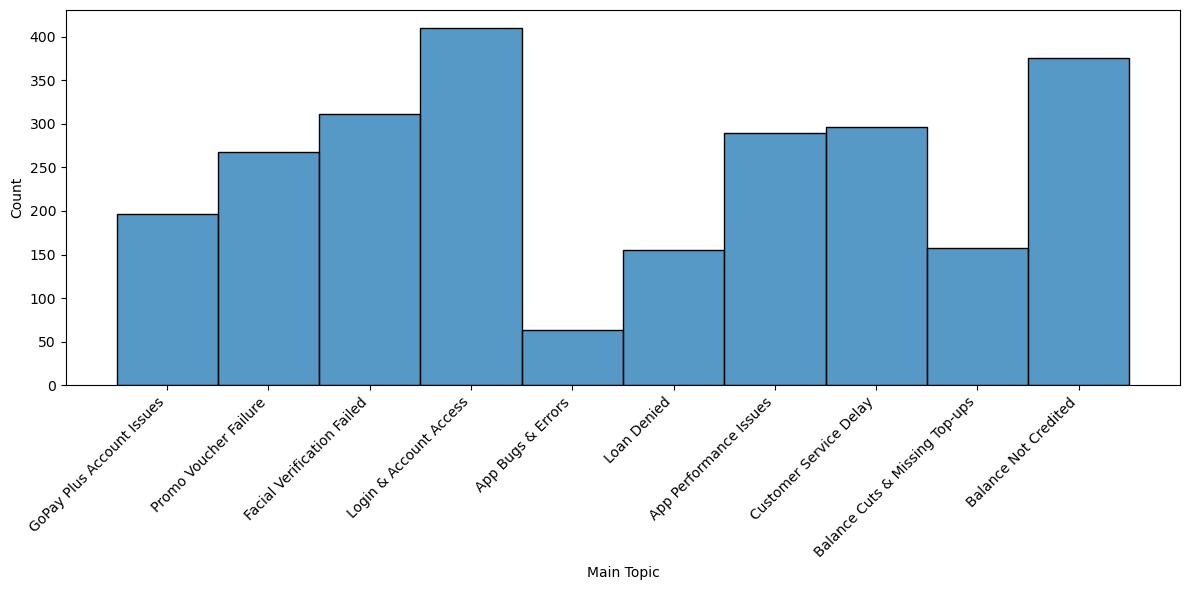

In [90]:
plt.figure(figsize=(12, 6))
sns.histplot(data=positive_info, x="Main Topic")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

# 🎯 Conclusion